In [ ]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install matplotlib
!pip install pylatexenc
!pip install scipy
!pip install -U scikit-learn

!git clone https://github.com/IsaVia777/atelier_qml.git

# Lab 3: Classification
**Objectifs**
* Classifier des données avec 1 qubit
* Mesurer selon les axes $X$, $Y$, $Z$

In [36]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit
from qiskit_aer import Aer

SEED = 8398

In [37]:
import sys
sys.path.insert(0, '/content/atelier_qml')

from utils import *

In [38]:
# Les simulateurs qui seront utilisés dans ce laboratoire
qasm_sim = Aer.get_backend('qasm_simulator')
sv_sim = Aer.get_backend('statevector_simulator')

### Ensemble de données à 1D linéairement séparable

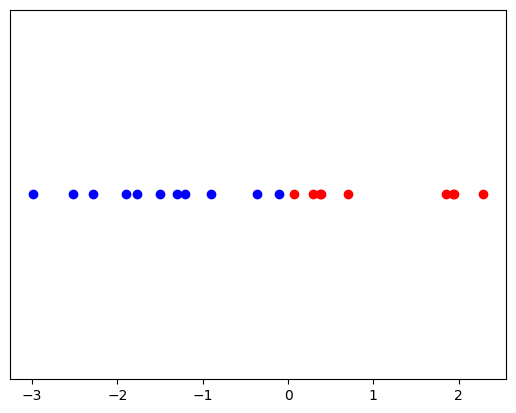

In [39]:
x, y, x0, x1 = get_seperable_data()
nb_features = 1

# Aperçu de l'ensemble de données. Étiquette 0 en bleu, étiquette 1 en rouge
plt.yticks([])
plt.scatter(x0, [0]*len(x0), color='blue')
plt.scatter(x1, [0]*len(x1), color='red')

Encodage par angle avec une rotation autour de l'axe des $X$.

In [40]:
def angle_embedding(x_params, nb_features):
    """
    Encodage par angle avec des portes RX.

    :param x_params: Liste des paramètres à encoder.
    :param nb_features: Le nombre de caractéristiques dans un vecteur de données.

    :return: Le circuit quantique qui fait de l'encodage par angle.
    """

    qc = QuantumCircuit(nb_features)

    for i in range(nb_features):
        qc.rx(x_params[i], i)

    return qc


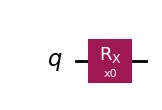

In [41]:
# Créer une liste de paramètres.
# Puisque les données sont 1D, on n'a besoin que d'un seul paramètre
x_params = [Parameter(f'x{str(i)}') for i in range(nb_features)]

# Circuit d'encodage par angle
qc = angle_embedding(x_params, nb_features)

qc.draw('mpl')

Encodage de la donnée [-1.20988039]:


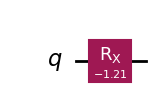

In [42]:
emb_circuit = qc.assign_parameters(x[0])

print(f'Encodage de la donnée {x[0]}:')
emb_circuit.draw('mpl')

### Projection dans l'espace des caractéristiques quantiques à l'aide de l'encodage par angle.

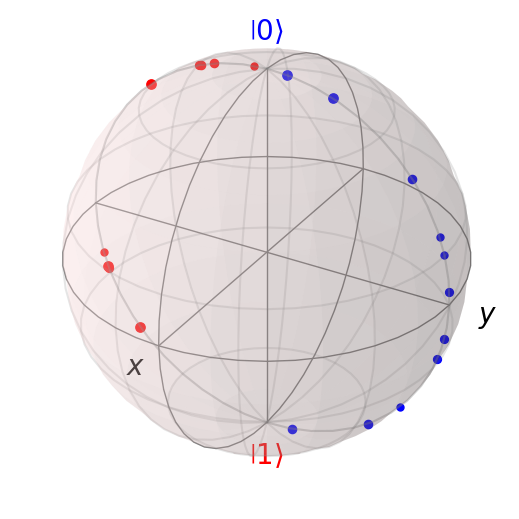

In [43]:
statevectors0 = get_statevector(qc, x0, x_params, sv_sim)
statevectors1 = get_statevector(qc, x1, x_params, sv_sim)
plot_bloch_visualization([statevectors0, statevectors1], ['b', 'r'])

## Implémentation de l'algorithme de classification

![lab3.png](https://github.com/IsaVia777/atelier_qml/blob/main/lab3.png?raw=1)

In [44]:
shots = 1024


def get_measurement_outcomes(data, emb_circuit, rot_circuit=None):
    """
    Exécution du circuit d'un classificateur binaire pour tous les vecteurs
    d'un ensemble de données.

    :param data:        Jeu de données à classifier
    :param emb_circuit: Circuit d'encodage des données par angle.
    :param rot_circuit: Circuit définissant la base de mesure.
                        Par défaut, mesure dans la base computationnelle (Z)

    :return: Une liste de résultats de mesure, un par vecteur de données présent
             dans l'ensemble.
    """
    # Ajouter le circuit définissant la base de mesure.
    if rot_circuit != None:
        emb_circuit = emb_circuit.compose(rot_circuit)

    circuits = []
    # Pour chaque point de l'ensemble de données
    for x_i in data:
        x_params = emb_circuit.parameters
        # Dictionnaire qui associe à chaque paramètre une caractéristique de la donnée
        x_params_dict = {p:v for (p,v) in zip(x_params, x_i)}
        # Remplacer les paramètres du circuit par leurs valeurs associées
        gqc = emb_circuit.assign_parameters(x_params_dict)
        # Ajouter la mesure de tous les qubits
        gqc.measure_all()
        circuits.append(gqc)

    # Exécuter les circuits "N" fois (déterminé par le nombre de shots)
    # result = execute(circuits, qasm_sim, shots=shots).result()
    result = qasm_sim.run(circuits, shots=shots).result()
    counts = result.get_counts()

    return counts

In [45]:
counts = get_measurement_outcomes(x, qc)
counts

[{'0': 683, '1': 341},
 {'1': 136, '0': 888},
 {'0': 418, '1': 606},
 {'1': 2, '0': 1022},
 {'1': 716, '0': 308},
 {'1': 216, '0': 808},
 {'1': 32, '0': 992},
 {'0': 193, '1': 831},
 {'1': 40, '0': 984},
 {'0': 657, '1': 367},
 {'0': 340, '1': 684},
 {'0': 91, '1': 933},
 {'1': 3, '0': 1021},
 {'1': 856, '0': 168},
 {'0': 521, '1': 503},
 {'0': 352, '1': 672},
 {'1': 27, '0': 997},
 {'1': 26, '0': 998},
 {'1': 664, '0': 360},
 {'0': 5, '1': 1019}]

In [46]:
def get_probabilities_from_counts(counts):
    """
    Calcul des probabilités d'appartenir à la classe 0 ou 1 à partir des résultats de
    mesure du circuit d'un classificateur binaire.
    """
    num_classes = 2
    probs = []

    # Pour les résultats de mesure de chaque point de l'ensemble de données
    for dict_meas in counts:
        # On compte le nombre de fois où on a observer 0 et 1 respectivement
        indiv_probs = np.zeros(num_classes)
        indiv_probs[0] = dict_meas.get('0', 0)
        indiv_probs[1] = dict_meas.get('1', 0)
        # On traduit le nombre d'observations de 0 et 1 en probabilités
        indiv_probs /= shots
        probs.append(indiv_probs)

    return np.round(probs, decimals=3)

In [47]:
probs = get_probabilities_from_counts(counts)
probs

array([[0.667, 0.333],
       [0.867, 0.133],
       [0.408, 0.592],
       [0.998, 0.002],
       [0.301, 0.699],
       [0.789, 0.211],
       [0.969, 0.031],
       [0.188, 0.812],
       [0.961, 0.039],
       [0.642, 0.358],
       [0.332, 0.668],
       [0.089, 0.911],
       [0.997, 0.003],
       [0.164, 0.836],
       [0.509, 0.491],
       [0.344, 0.656],
       [0.974, 0.026],
       [0.975, 0.025],
       [0.352, 0.648],
       [0.005, 0.995]])

In [48]:
def get_accuracy(probs, targets):
    """
    Calcul la précision obtenue par le classificateur binaire

    :param probs:   La probabilité prédite par le classificateur d'appartenir à la classe 0 ou 1,
                    pour chaque vecteur de l'ensemble de données.
    :param targets: La liste des étiquettes.

    :return: La précision du classificateur.
    """
    # La classe prédite est celle avec la plus grande probabilité
    predict = np.argmax(probs, axis=1)
    targets = np.array(targets).reshape(predict.shape)
    # On compte le nombre de fois où la prédiction correspond à l'étiquette et on divise
    # par le nombre total de prédictions.
    accuracy = np.sum(predict == targets) / len(predict)

    return accuracy

In [49]:
accuracy = get_accuracy(probs, y)
print(f'>\n> La précision de notre classificateur est de {accuracy*100}%.\n>')

>
> La précision de notre classificateur est de 50.0%.
>


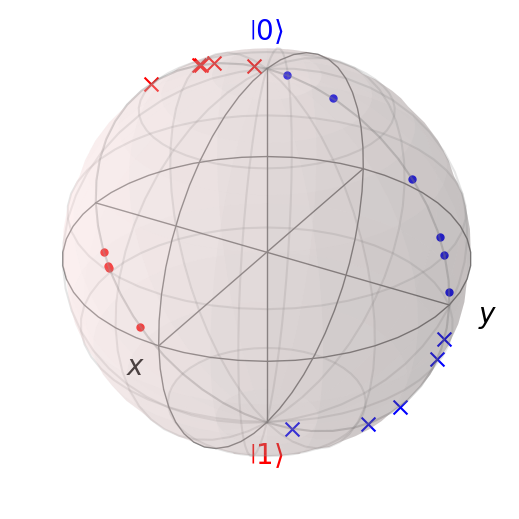

In [50]:
predict = np.argmax(probs, axis=1)
plot_bloch_visualization([statevectors0, statevectors1], x=x, x0=x0, x1=x1, score=(predict==np.array(y).reshape(predict.shape)))

Les points marqués d'un **X** sont ceux qui ont été mal classifiés.<br>
Êtes-vous surpris?<br>
Comment peut-on faire mieux?

## Mesure le long de l'axe Y

Pour mesurer le long de l'axe $Y$, on doit appliquer la porte $S^\dagger$, suivie de la porte $H$.<br>
La porte $S^\dagger$ applique une rotation de $\pi/2$ dans le sens horaire autour de l'axe $Z$.

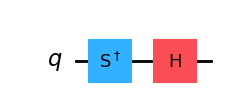

In [51]:
qc_ybasis = QuantumCircuit(1)
qc_ybasis.sdg(0)
qc_ybasis.h(0)

qc_ybasis.draw('mpl')

In [52]:
counts = get_measurement_outcomes(x, qc, qc_ybasis)
probs = get_probabilities_from_counts(counts)
accuracy = get_accuracy(probs, y)
print(f'>\n> La précision de notre classificateur est de {accuracy*100}%.\n>')

>
> La précision de notre classificateur est de 100.0%.
>


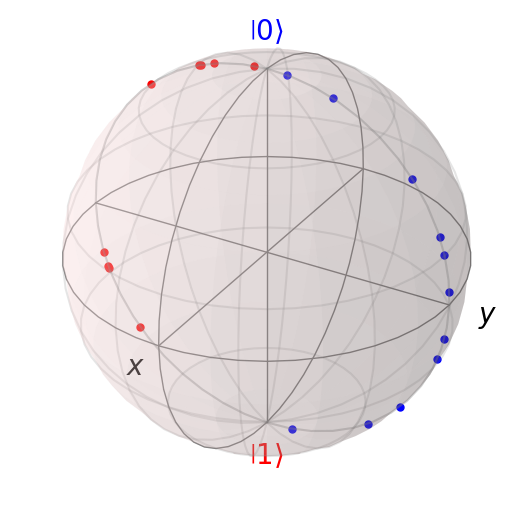

In [53]:
predict = np.argmax(probs, axis=1)
plot_bloch_visualization([statevectors0, statevectors1], x=x, x0=x0, x1=x1, score=(predict==np.array(y).reshape(predict.shape)))

## Exercice 3
 * Créez la fonction d'encodage par angle pour que les rotations soient effectuées autour de l'axe $Y$.
 * Créez le circuit quantique `qc_xbasis` qui effectue une mesure dans la base des $X$ en ajoutant simplement une porte Hadamard.<br>Validez que vous obtenez 100% de précision avec ce circuit.

In [67]:
def angle_embedding_ry(x_params, nb_features):
    """
    Encodage par angle avec des portes RY.

    :param x_params: Liste des paramètres à encoder.
    :param nb_features: Le nombre de caractéristiques dans un vecteur de données.

    :return: Le circuit quantique qui fait de l'encodage par angle.
    """

    qc = QuantumCircuit(nb_features)

    for i in range(nb_features):
        qc.ry(x_params[i]+np.pi, i)

    return qc

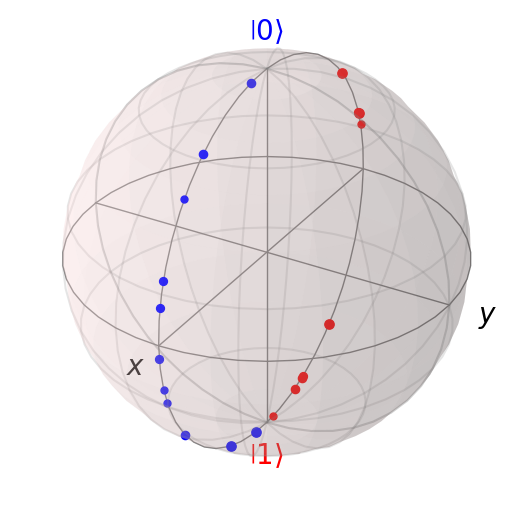

In [68]:
qc = angle_embedding_ry(x_params, 1)
statevectors0 = get_statevector(qc, x0, x_params, sv_sim)
statevectors1 = get_statevector(qc, x1, x_params, sv_sim)
plot_bloch_visualization([statevectors0, statevectors1], ['b', 'r'])

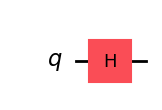

In [69]:
## Votre code ici

qc_xbasis = QuantumCircuit(1)
qc_xbasis.h(0)

qc_xbasis.draw('mpl')

In [70]:
## Votre code ici

counts = get_measurement_outcomes(x, qc, qc_xbasis)
probs = get_probabilities_from_counts(counts)
accuracy = get_accuracy(probs, y)
print(f'>\n> La précision de notre classificateur est de {accuracy*100}%.\n>')


>
> La précision de notre classificateur est de 100.0%.
>
